In [84]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit

# Project 2: Estimating Thorium Isotope Content From Decay Curves

To estimate the Thorium content we need to fit the data with exponential decay curves and compare the obtained half-lifes with experimentally known values for the pure substances.

First, we load the data and convert the provided reference half-lifes to hours:

In [85]:
# radioactive_decay_data.csv
time, mol1, mol2, mol3 = np.loadtxt('radioactive_decay_data.csv',skiprows=1,delimiter=',',unpack=True)

molarity = np.array([mol1, mol2, mol3])

In [86]:
# Reference half-lifes provided in task:
halflife = {
"Th-227": 18.68*24, # Tage
"Th-228": 1.91*356*24, #Jahre
"Th-231": 25.52, # Stunden
"Th-233": 21.83/60. # Minuten
}

print(halflife)

{'Th-227': 448.32, 'Th-228': 16319.039999999997, 'Th-231': 25.52, 'Th-233': 0.3638333333333333}


Now we can calculate mean and standard deviations across the three measurement series provided, and plot the curves:

In [87]:
#calculate mean and standard deviation
mean_mol = np.mean(molarity,axis=0)
std_mol  = np.std(molarity,axis=0)

In [88]:
plt.errorbar(time,mean_mol,yerr=std_mol,fmt='o' )
#plt.plot(conc_dat,pred_ext_wls,color='r')

#plt.xticks([1.00e-05, 3.25e-05, 5.50e-05, 7.75e-05, 1.00e-04],['0.01', '0.033', '0.055', '0.078', '0.1'])

plt.xlabel('Time / h',fontsize=16)
plt.ylabel('Amount of Thorium / M',fontsize=16)

#plt.legend()

plt.xlim([0,1000])
plt.ylim([0,5.2])
#print(lin_model.coef_,lin_model.intercept_)

plt.show()

Looking at this data it becomes clear that it will be difficult to detect the presence of Th-228 and Th-233, since their life-times are much longer/shorter than the range of the data. Nonetheless, we have the information that up to three isotopes may be in the sample, so let's fit a tri-exponential curve. The starting values are somewhat arbitrary, I just chose three times that are of different orders of magnitudes. We could also start from known values though.

In [90]:
def tri_exponential_decay(t,A,B,C,tauA,tauB,tauC):
    return A*np.exp(-t/tauA) + B*np.exp(-t/tauB) + C*np.exp(-t/tauC)

popt, pcov = curve_fit(tri_exponential_decay, time, mean_mol, 
                       p0=(0.3,0.3,0.3,1,10,100), sigma=std_mol)

Let's look at the resulting parameters. Note that we convert the exponential life-times $\tau$ to half-lifes $t_{1/2}$, so that we can compare with the reference:

In [91]:
A,B,C,tauA,tauB,tauC = popt 
sigA, sigB, sigC, sigtauA, sigtauB, sigtauC = np.sqrt(np.diag(pcov))

print(f"---Relative Components:")
print(f"A = {A:5.3f} +/- {sigA:5.3f} \nB = {B:5.3f} +/- {sigB:5.3f} \nC = {C:5.3f} +/- {sigC:5.3f}")
print(f"---Lifetimes:")
print(f"tauA = {tauA:5.3f} +/- {sigtauA:5.3f} h \ntauB = {tauB:5.3f} +/- {sigtauB:5.3f} h \ntauC = {tauC:5.3f} +/- {sigtauC:5.3f} h")
print(f"---Halflife:")
print(f"t12A = {np.log(2)*tauA:5.3f} +/- {np.log(2)*sigtauA:5.3f} h \nt12B = {np.log(2)*tauB:5.3f} +/- {np.log(2)*sigtauB:5.3f} h \nt12C = {np.log(2)*tauC:5.3f} +/- {np.log(2)*sigtauC:5.3f} h") 
print(f"---Reference Values:")
print(halflife)

---Relative Components:
A = 3.574 +/- 158081.477 
B = 0.381 +/- 158081.492 
C = 1.001 +/- 0.005
---Lifetimes:
tauA = 37.136 +/- 13743.485 h 
tauB = 37.135 +/- 128918.469 h 
tauC = 637.077 +/- 3.161 h
---Halflife:
t12A = 25.741 +/- 9526.258 h 
t12B = 25.740 +/- 89359.474 h 
t12C = 441.588 +/- 2.191 h
---Reference Values:
{'Th-227': 448.32, 'Th-228': 16319.039999999997, 'Th-231': 25.52, 'Th-233': 0.3638333333333333}


Interestingly, two of the life-times came out identicaly as 25.74 h, while the third one is 448.32 h. These actually matches quite well with Th-231 and Th-227, respectively. But something is fishy with the error bars for the Th-231 values (A,B,tauA, and tauB)! This is because our fit is ill-conditioned: We actually don't need a tri-exponential function, that's why two of the lifetimes came out identically. Therefore the error estimate is not reliable here. We can move to a simpler bi-exponential fit instead:

In [92]:
def bi_exponential_decay(t,A,B,tauA,tauB):
    return A*np.exp(-t/tauA) + B*np.exp(-t/tauB) 

popt, pcov = curve_fit(bi_exponential_decay, time, mean_mol, 
                       p0=(0.3,0.3,1,1), sigma=std_mol)

In [93]:
A,B,tauA,tauB = popt 
sigA, sigB, sigtauA, sigtauB = np.sqrt(np.diag(pcov))

print(f"---Relative Components:")
print(f"A = {A:5.3f} +/- {sigA:5.3f} \nB = {B:5.3f} +/- {sigB:5.3f}")
print(f"---Lifetimes:")
print(f"tauA = {tauA:5.3f} +/- {sigtauA:5.3f} h \ntauB = {tauB:5.3f} +/- {sigtauB:5.3f} h")
print(f"---Halflife:")
print(f"t12A = {np.log(2)*tauA:5.3f} +/- {np.log(2)*sigtauA:5.3f} h \nt12B = {np.log(2)*tauB:5.3f} +/- {np.log(2)*sigtauB:5.3f} h") 
print(f"---Reference Values:")
print(halflife)

---Relative Components:
A = 3.955 +/- 0.024 
B = 1.001 +/- 0.004
---Lifetimes:
tauA = 37.136 +/- 0.283 h 
tauB = 637.077 +/- 2.504 h
---Halflife:
t12A = 25.741 +/- 0.196 h 
t12B = 441.588 +/- 1.736 h
---Reference Values:
{'Th-227': 448.32, 'Th-228': 16319.039999999997, 'Th-231': 25.52, 'Th-233': 0.3638333333333333}


This looks much more reasonable. The Th-227 value is not quite within the error bars, but at least reasonably close. To get a more precise estimate, we would have needed a longer measurement in this case (1000 hours is just a little more than two half-lifes for this sample). Finally, let's plot the fitting curve and the individual components.

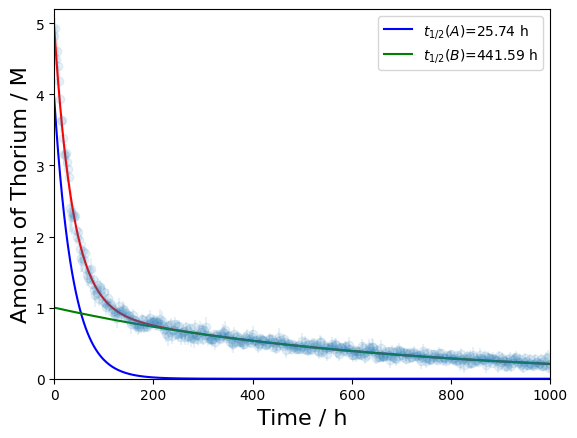

In [94]:
plt.errorbar(time,mean_mol,yerr=std_mol,fmt='o',alpha=0.1)
plt.plot(time,bi_exponential_decay(time,A,B,tauA,tauB),color='r')

plt.plot(time,A*np.exp(-time/tauA),color='b',label='$t_{1/2}(A)$=25.74 h')
plt.plot(time,B*np.exp(-time/tauB),color='g',label='$t_{1/2}(B)$=441.59 h')

#plt.xticks([1.00e-05, 3.25e-05, 5.50e-05, 7.75e-05, 1.00e-04],['0.01', '0.033', '0.055', '0.078', '0.1'])

plt.xlabel('Time / h',fontsize=16)
plt.ylabel('Amount of Thorium / M',fontsize=16)

#plt.legend()

plt.xlim([0,1000])
plt.ylim([0,5.2])
#print(lin_model.coef_,lin_model.intercept_)

plt.legend()
plt.show()

Important: log is not equal to log10!

In [95]:
print(np.log(2),np.log10(2))

0.6931471805599453 0.3010299956639812
